In [1]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import seaborn as sns
from PIL import Image
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.label_maps import CLASS_DICT
from user_constants import DATA_PATH_DICT
%matplotlib inline

In [2]:
# Constants
DATA = 'CIFAR'
BATCH_SIZE = 8
NUM_WORKERS = 8

DATA_SHAPE = 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)

In [3]:
# Load dataset
dataset_function = getattr(datasets, DATA)
dataset = dataset_function(DATA_PATH_DICT[DATA])

In [4]:
# Load model
model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': f'./models/{DATA}.pt'
}
model, _ = model_utils.make_and_restore_model(**model_kwargs)
model.eval()

=> loading checkpoint './models/CIFAR.pt'
=> loaded checkpoint './models/CIFAR.pt' (epoch 153)


DataParallel(
  (module): AttackerModel(
    (normalizer): InputNormalize()
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layer1): SequentialWithArgs(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (shortcut): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bia

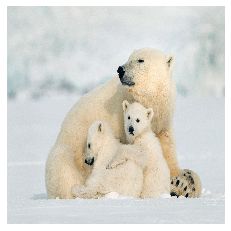

In [5]:
# Load images
img = np.asarray(Image.open('./sample_inputs/img_bear.jpg').resize((224, 224)))[None,:]
img = img.repeat(BATCH_SIZE, 0)

mask1 = np.asarray(Image.open('./sample_inputs/mask_bear1.png').resize((224, 224)))[None,:, :, None].copy()
mask2 = np.asarray(Image.open('./sample_inputs/mask_bear2.png').resize((224, 224)))[None,:, :, None].copy()
mask3 = np.asarray(Image.open('./sample_inputs/mask_bear3.png').resize((224, 224)))[None,:, :, None].copy()

mask1 = mask1.repeat(BATCH_SIZE, 0).repeat(3, 3)
mask2 = mask2.repeat(BATCH_SIZE, 0).repeat(3, 3)
mask3 = mask3.repeat(BATCH_SIZE, 0).repeat(3, 3)

mask1 = ch.clamp(ch.tensor(np.transpose(mask1, (0, 3, 1, 2))), 0, 1)
mask2 = ch.clamp(ch.tensor(np.transpose(mask2, (0, 3, 1, 2))), 0, 1)
mask3 = ch.clamp(ch.tensor(np.transpose(mask3, (0, 3, 1, 2))), 0, 1)

plt.imshow(img[0])
plt.axis('off')
plt.show()

In [6]:
# Custom loss for painting
def paint_loss_wrapper(im_targ, mask, normalizer, lambdar=10*9):
    def paint_loss(mod, inp, targ):
        op, rep = mod(normalizer(inp), with_latent=True, fake_relu=True)
        repg = ch.gather(rep, 1, targ[:, None])
        loss = 10**(-1)* ch.mean(repg, dim=1)
        loss_l2 = (((im_targ - inp) * (1 - mask) )**2).mean(-1).mean(-1).mean(-1)
        loss -= lambdar * loss_l2
        return loss, None
    return paint_loss

def maximize_activation(xin, main, ain):
    kwargs['custom_loss'] = paint_loss_wrapper(xin.cuda(), main.cuda(), model.module.normalizer)
    _, xadv = model(xin, ain, make_adv=True, **kwargs)
    return xadv.detach().clone()

In [7]:
# PGD Parameters
kwargs = {
        'constraint':'2',
        'eps': 70,
        'step_size': 1,
        'iterations': 140, 
        'targeted': False,
        'should_normalize': False
}

In [8]:
# Add features to image
img_orig = ch.tensor(np.transpose(img / 254., (0, 3, 1, 2)))
img_paint_list = [img[0]]

for i, (act, mask) in enumerate(zip([768, 675, 1349], 
                                    [mask3, mask1, mask2])): 
    act_targ = act*ch.ones((BATCH_SIZE, )).long()
    img_paint = maximize_activation(img_orig.float(), mask.float(), act_targ)
    img_paint_list.append(img_paint.detach().cpu().numpy()[0].transpose(1, 2, 0))
    img_orig = img_paint.clone()

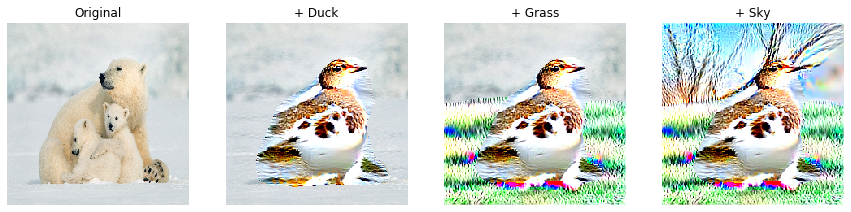

In [9]:
# Visualize results
fig, axarr = plt.subplots(1, len(img_paint_list), figsize=(15, 4))

for i, (il, t) in enumerate(zip(img_paint_list, 
                                ['Original', '+ Duck', '+ Grass', '+ Sky'])):
    axarr[i].imshow(il)
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].axis('off')
    axarr[i].set_title(t)